In [1]:
# For reproducibility
from config import reproducible
SEED = reproducible()

Global seed set to 42


## Config - checkpoint 지정

In [2]:
from pathlib import Path
from config import PATH_LOG

from data.clf_loaders import get_dataset_info


CWD = Path.cwd()

task_name = 'farmsall'   # 선택 - PoC:'cifar10', Farmsall:'farmsall'
model_name = 'vit16'
log_version = 16    # None: next avaiable version
log_path = PATH_LOG / task_name / f'version_{log_version}'
ckpt_file = log_path / 'checkpoints' / 'epoch=39-step=204360.ckpt'
dsinfo = get_dataset_info(task_name=task_name)
num_classes = dsinfo['num_classes']
simple_transformation = False

Global seed set to 42


# Classifier 사용 예시

### 분류모델 Loading

In [3]:
import torch
from trainers import ClassificationTask
from models import get_model

model_instance = get_model(model_name, num_classes=num_classes)
task = ClassificationTask.load_from_checkpoint(ckpt_file,
                                        model=model_instance,
                                        # 추가 parameter들이 들어갈 수 있음
                                        map_location=torch.device('cpu')
                                        )
model = task.model  # the loaded model

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/kpark/venv/farms/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


### Prediction을 위한 Image 1개 확인

정답: 0


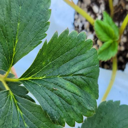

In [4]:
from torchvision import transforms
from data.common import get_default_transforms
from data.clf_loaders import OpensetDataModule, CropDiseaseDataModule

input_params = model.input_params
size = input_params['size']
crop_size = input_params['crop_size']
mean = input_params['mean']
std = input_params['std']

if simple_transformation:
    transform = {'train': transforms.ToTensor(), 'valid': transforms.ToTensor()}
else:
    transform = get_default_transforms(mean=mean, std=std, crop_size=crop_size, size=size)

if task_name != 'farmsall':    # For PoC
    dm = OpensetDataModule(transform=None, num_workers=1)
else:
    dm = CropDiseaseDataModule(transform=None, num_workers=1)
dm.setup('valid')
rawimg, label = dm.valset[0]
# rawimg = Image.open(PATH_DATASET / 'valid' / 'd2' / '1128863_20211209_1_1_a1_1_2_13_1_0.jpg')
# label = 1
print('정답:', label)
rawimg.resize((128,128))

### 분류모델을 통해 prediction 실행

In [5]:
from models import predict_img
device = 'cpu'
print('예측값:', predict_img(model, rawimg, transform['valid'], device=device))

예측값: 0


# OOD Detector 예시

### OOD Detector Loading

In [6]:

from models.ood import load_detector

experiment = 'farmsall_vit16_23-08-28T10:03:10'

detector_name = 'RMD' #'Mahalanobis'
detector_path = log_path / experiment / f'ood_detector_{task_name}_{model_name}_{detector_name}.pkl'
detector = load_detector(detector_path)
detector_path

PosixPath('/home/kpark/farmsall/logs/farmsall/version_16/farmsall_vit16_23-08-28T10:03:10/ood_detector_farmsall_vit16_RMD.pkl')

### OOD Detector를 통해 Image 1개의 OOD여부 확인

In [7]:
from data.ood_loaders import OpensetOODDataModule, CropDiseaseOODDataModule

if simple_transformation:
    transform = {'train': transforms.Compose([transforms.Resize(size),
                                    transforms.CenterCrop(crop_size),
                                    transforms.ToTensor()])}
    transform['valid'] = transform['train']
else:
    transform = get_default_transforms(mean=mean, std=std, crop_size=crop_size, size=size)

# 입력 image 확인을 위해, transform을 적용하지 않음
if task_name != 'farmsall':    # For PoC
    dm = OpensetOODDataModule(transform=None, num_workers=1)
else:
    dm = CropDiseaseOODDataModule(transform=None, num_workers=1)
dm.setup('fit')
dm.setup('valid')

Global seed set to 42


In [8]:
from models import predict_ood

1. IN 이미지

정답: 0


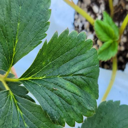

In [9]:
rawimg_in, label_in = dm.testset_in[0]
print('정답:', label_in)
rawimg_in.resize((128,128))

In [10]:
detection, score = predict_ood(detector, rawimg_in, transform['valid'], device)
print(f'OOD 예측: {detection} ({score:.5f}, {detector.threshold:.5f})')

OOD 예측: False (0.50000, 0.50001)


2. OOD 이미지

정답: OOD -1


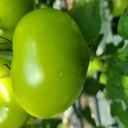

In [11]:
rawimg_ood, label_ood = dm.testset_ood[4000]
print('정답:', 'OOD' if label_ood == -1 else 'IN', label_ood)
rawimg_ood.resize((128,128))

In [12]:
detection, score = predict_ood(detector, rawimg_ood, transform['valid'], device)
print(f'OOD 예측: {detection} ({score:.5f}, {detector.threshold:.5f})')

OOD 예측: True (0.50001, 0.50001)


## 앙상블 모델을 활용

In [13]:
from models import ensemble_oods
from models.ood import load_detector, set_device

detectors_to_use = ['RMD', 'Mahalanobis', 'EnergyBased']
detectors = [load_detector(log_path / experiment / f'ood_detector_{task_name}_{model_name}_{detector_name}.pkl')
                for detector_name in detectors_to_use]
detectors = [set_device(detector, device) for detector in detectors]
pred, stat = ensemble_oods(detectors, rawimg_ood, transform['valid'], device=device)
print(f'OOD 예측: {pred}', f'({stat})')

OOD 예측: True ([True, True, True])


# OOD detector를 고려한 분류기 사용 예시

In [14]:
from models import predict  # generalized predictor

1. IN 이미지

In [15]:
pred, score = predict(model, [detector], rawimg_in, transform['valid'], device)
print(f'분류 정답: {label_in}')
print(f'분류 예측: {pred}')

device: cpu
분류 정답: 0
분류 예측: 0


2. OOD 이미지

In [16]:
pred, score = predict(model, [detector], rawimg_ood, transform['valid'], device)
print(f'분류 정답: {label_ood}')
print(f'분류 예측: {pred} ({score:.5f}, {detector.threshold:.5f})')

분류 정답: -1
분류 예측: -1 (0.50001, 0.50001)


# 실데이터 및 New 데이터셋 테스트

In [17]:
import random
from torch.utils.data import Dataset
from utils.vision import show_imageset
from config import PATH_DATA_FARMSALL_OOD

num_to_show = 32
show_transform = transforms.Compose([transforms.Resize(size),
                                    transforms.CenterCrop(crop_size),
                                transforms.ToTensor()])
def predict_samples(dataset_random:Dataset):
    indices = random.sample(range(0, len(dataset_random)), num_to_show)
    show_imageset(dataset_random, indices, transform=show_transform)

    preds = [predict(model, [detector], dataset_random[idx][0], transform['valid'], device)[0] for idx in indices]
    if sum(preds) == -num_to_show:
        print(sum(preds), sum(preds) == -num_to_show)
    else:
        print('Some images are not classified as OOD!')
        failures = [indices[idx] for idx, pred in enumerate(preds) if pred != -1]
        show_imageset(dataset_random, failures, transform=show_transform)

1. NINCO

In [18]:
from pytorch_ood.dataset.img import NINCO
dataset = NINCO(PATH_DATA_FARMSALL_OOD, download=True)


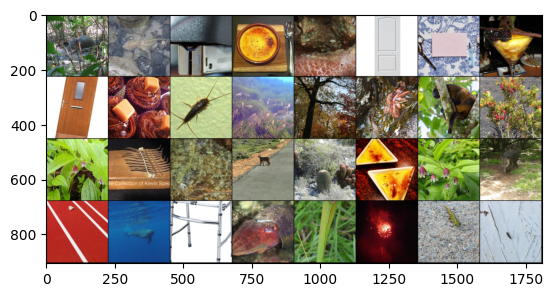

-32 True


In [45]:
predict_samples(dataset)

2. Char74k

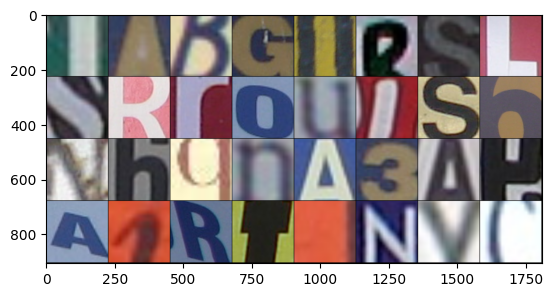

-32 True


In [22]:
from pytorch_ood.dataset.img import Chars74k
predict_samples(Chars74k(PATH_DATA_FARMSALL_OOD, download=True))

In [23]:
from pytorch_ood.dataset.img import iNaturalist